In [287]:
import numpy as np
import cv2
import torch
import glob as glob
import torchvision
from torchvision.ops import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from IPython.display import Image, display
import pytesseract

In [288]:
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [289]:
# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=3).to(device)
model.load_state_dict(torch.load(
    '/home/dhruv/Projects/complete-ocr/rcnn_model/model100.pth', map_location=device
))
model.eval()

# classes: 0 index is reserved for background
CLASSES = [
    'bkg', 'table', 'cell'
]
# any detection having score below this will be discarded
detection_threshold = 0.5

### Image File Input

In [290]:
image_name = '../DEMO/12.jpg'

In [291]:
image = cv2.imread(image_name)
orig_image = image.copy()
# BGR to RGB
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
# make the pixel range between 0 and 1
image /= 255.0
# bring color channels to front
image = np.transpose(image, (2, 0, 1)).astype(float)
# convert to tensor
image = torch.tensor(image, dtype=torch.float)
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image)

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
# carry further only if there are detected boxes
if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # get all the predicited class names
    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

    # draw the bounding boxes and write the class name on top of it
    lines = []
    n, c, h, w = image.shape
    for j, box in enumerate(draw_boxes):
        cv2.rectangle(orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 0, 255), 2)
        cv2.putText(orig_image, pred_classes[j], 
                    (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                    2, lineType=cv2.LINE_AA)
    #cv2.imshow('Prediction', orig_image)
    #cv2.waitKey(1)
    cv2.imwrite(f"{image_name[:-4]}_PRED.jpg", orig_image,)
print('PREDICTION COMPLETE')

PREDICTION COMPLETE


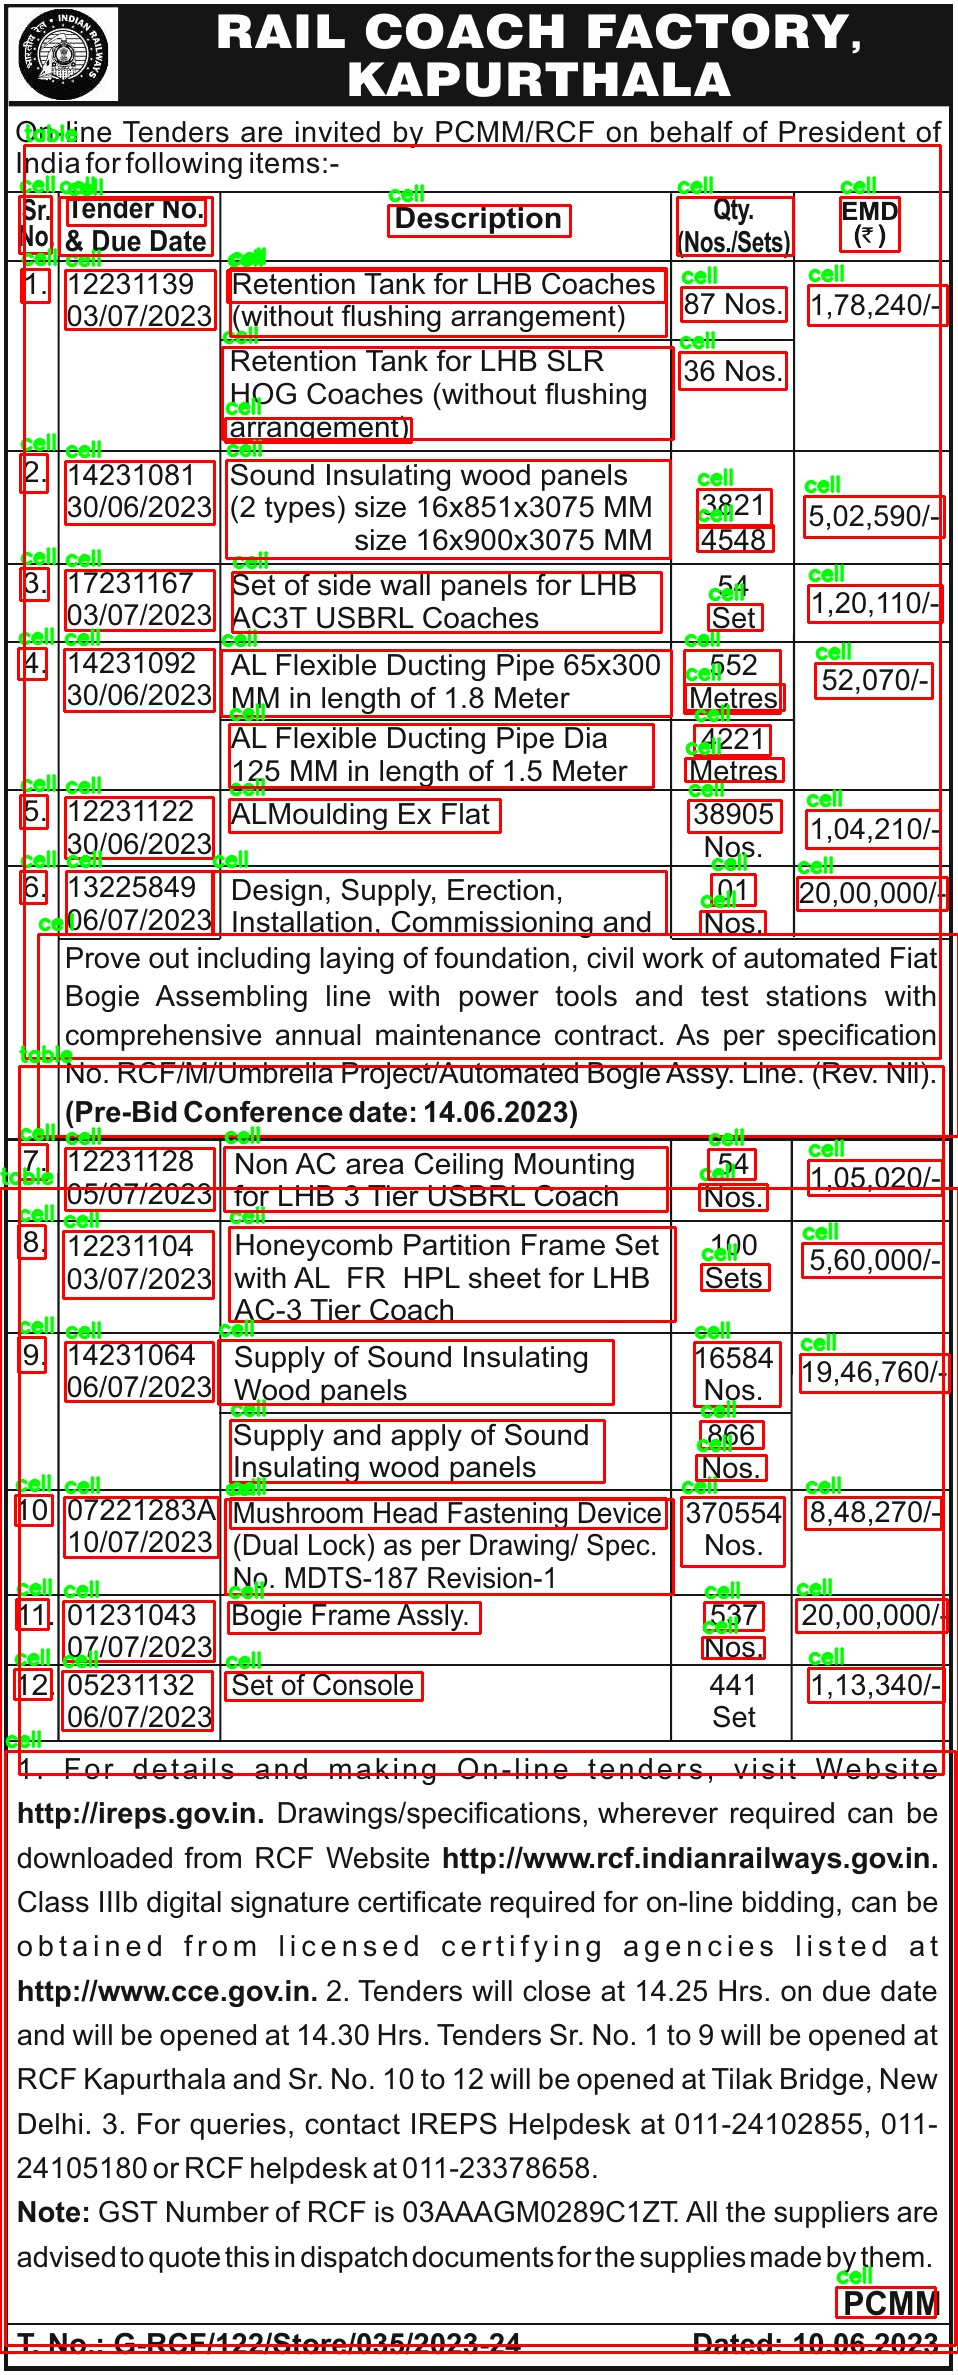

In [292]:
display(Image(filename=f'{image_name[:-4]}_PRED.jpg'))

### Process Model Results

In [293]:
# Returns true if two rectangles b1 and b2 overlap, b is of the form [x1, y1, x2, y2]
def do_overlap(b1, b2):
    if (b1[0] >= b2[2]) or (b1[2] <= b2[0]) or (b1[3] <= b2[1]) or (b1[1] >= b2[3]):
         return False
    else:
        return True

# Get cells which are a part of a table
def get_cells_from_table(tab, cells):
    tablecells = []
    for c in cells:
        overlap = do_overlap(tab, c)
        if overlap:
            tablecells.append(c)
    return tablecells

def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    assert iou >= 0
    return iou

def perform_nms(boxes, scores, nms_threshold):
    dets = torch.Tensor(boxes)
    scores = torch.Tensor(scores)
    res = nms(dets, scores, nms_threshold)
    final_boxes =[]
    for ind in res:
        final_boxes.append(boxes[ind])
    return final_boxes

In [294]:
# Trim classes for top k boxes predicted over threshold score
classes = pred_classes[:len(boxes)]

# Collect table and cells 
unfiltered_tables = []
unfiltered_cells = []
# Collect Scores
table_scores = []
cell_scores = []
for i in range(len(boxes)):
    if classes[i] == 'table':
        unfiltered_tables.append(boxes[i])
        table_scores.append(scores[i])
    else:
        unfiltered_cells.append(boxes[i])
        cell_scores.append(scores[i])

tables = []
cells = []
# Perform NMS to resolve overlap issue
if len(unfiltered_tables):
    tables = perform_nms(unfiltered_tables, table_scores, 0.1)
if len(unfiltered_cells):
    cells = perform_nms(unfiltered_cells, cell_scores, 0.01)


In [295]:
tables

[array([  24,  145,  940, 1058], dtype=int32),
 array([   0, 1188,  958, 2352], dtype=int32)]

#### Do this for every table of the page

In [304]:
# Select a table here
ind = 1

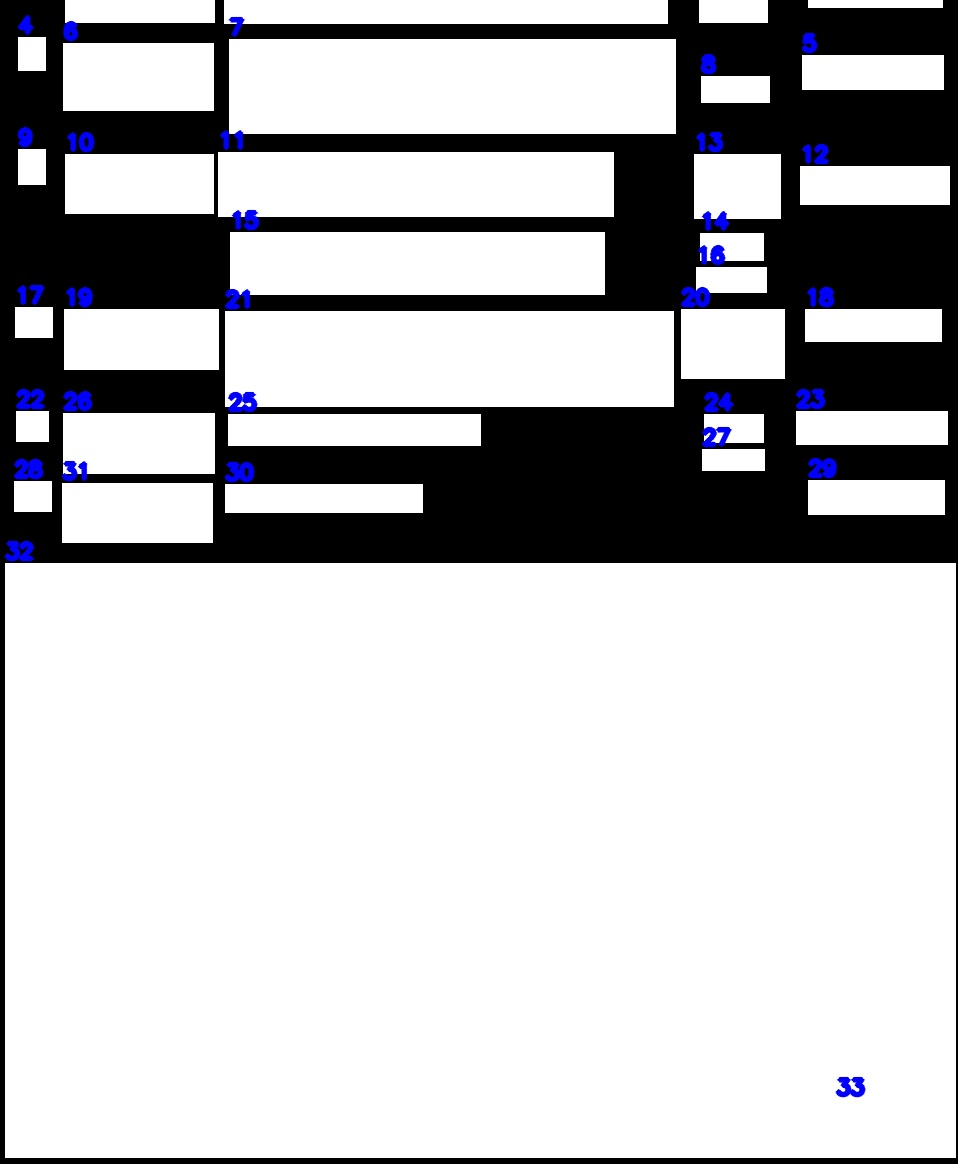

In [305]:
tabcells = get_cells_from_table(tables[ind], cells)

# Sort cells based on y coordinates
strcells = sorted(tabcells, key=lambda b:b[1]+b[3], reverse=False)
struc_image = cv2.imread(image_name)
struc_image = struc_image * 0
for j, box in enumerate(strcells):
    cv2.rectangle(struc_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(255, 255, 255), -1)
    cv2.putText(struc_image, str(j), (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 1), 4, lineType=cv2.LINE_AA)
cropped_image = struc_image[tables[ind][1]:tables[ind][3], tables[ind][0]:tables[ind][2]]

cv2.imwrite(f"{image_name[:-4]}_struc_PRED.jpg", cropped_image)
display(Image(filename=f"{image_name[:-4]}_struc_PRED.jpg"))

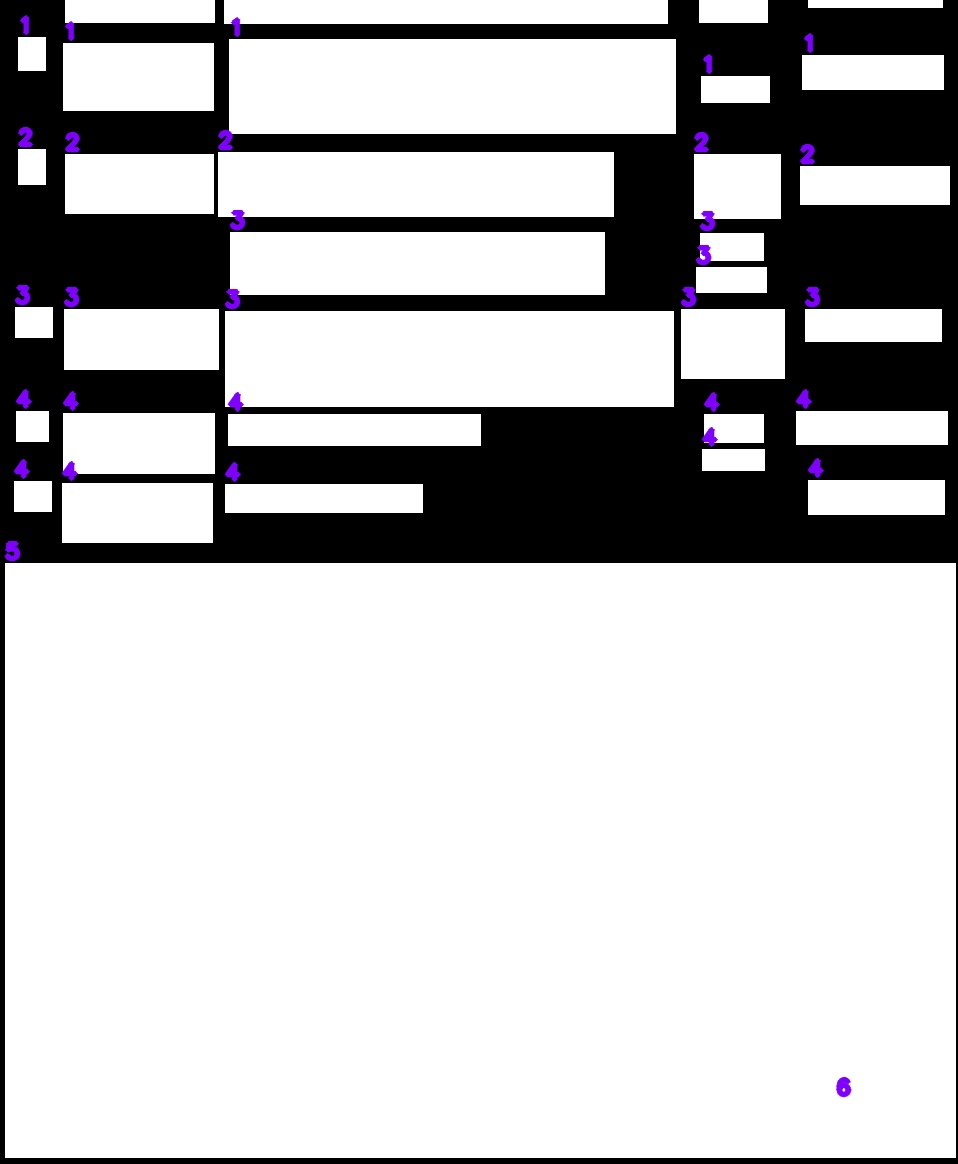

In [306]:
# Calculate Mean height
cell_heights = [c[3] - c[1] for c in tabcells]
mean_height = int(np.mean(cell_heights))

# Assign row to each cell based on y coordinate wise arrangement 
cellrow = [0]
assign_row = 0
for i in range(len(strcells) - 1):
    consec_cell_height = strcells[i + 1][1] - strcells[i][1]
    if consec_cell_height > 0.6667 * mean_height:
        assign_row = assign_row + 1
    cellrow.append(assign_row)

struc_image = cv2.imread(image_name)
struc_image = struc_image * 0
for j, box in enumerate(strcells):
    cv2.rectangle(struc_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(255, 255, 255), -1)
    cv2.putText(struc_image, str(cellrow[j]), (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 128), 4, lineType=cv2.LINE_AA)
cropped_image = struc_image[tables[ind][1]:tables[ind][3], tables[ind][0]:tables[ind][2]]

cv2.imwrite(f"{image_name[:-4]}_ROW_PRED.jpg", cropped_image)
display(Image(filename=f"{image_name[:-4]}_ROW_PRED.jpg"))

In [307]:
# Get number of rows and columns
rows = list(set(cellrow))
nrows = len(rows)

cellrows = {}
for i in rows:
    row_wise_cells = []
    for j in range(len(strcells)):
        if i == cellrow[j]:
            row_wise_cells.append(strcells[j])
    row_wise_cells = sorted(row_wise_cells, key=lambda b:b[0], reverse=False)
    cellrows[i] = row_wise_cells

tableresponse = {}
tableresponse['bbox'] = tables[ind]
tableresponse['nrows'] = nrows
tableresponse['cellrows'] = cellrows

In [308]:
tableresponse

{'bbox': array([   0, 1188,  958, 2352], dtype=int32),
 'nrows': 7,
 'cellrows': {0: [array([  65, 1148,  214, 1210], dtype=int32),
   array([ 224, 1147,  667, 1211], dtype=int32),
   array([ 699, 1184,  767, 1210], dtype=int32),
   array([ 808, 1160,  942, 1195], dtype=int32)],
  1: [array([  18, 1225,   45, 1258], dtype=int32),
   array([  63, 1231,  213, 1298], dtype=int32),
   array([ 229, 1227,  675, 1321], dtype=int32),
   array([ 701, 1264,  769, 1290], dtype=int32),
   array([ 802, 1243,  943, 1277], dtype=int32)],
  2: [array([  18, 1337,   45, 1372], dtype=int32),
   array([  65, 1342,  213, 1401], dtype=int32),
   array([ 218, 1340,  613, 1404], dtype=int32),
   array([ 694, 1342,  780, 1406], dtype=int32),
   array([ 800, 1354,  949, 1392], dtype=int32)],
  3: [array([  15, 1495,   52, 1525], dtype=int32),
   array([  64, 1497,  218, 1557], dtype=int32),
   array([ 225, 1499,  673, 1594], dtype=int32),
   array([ 230, 1420,  604, 1482], dtype=int32),
   array([ 681, 1497,  

## After function return

In [309]:
def get_cell_text(image, cellbbox, lang):
    cropped_image = image[cellbbox[1]:cellbbox[3], cellbbox[0]:cellbbox[2]]
    text = pytesseract.image_to_string(cropped_image, lang=lang, config='--psm 6')
    return text

def get_merged_cell(final_cells):
    if len(final_cells) == 1:
        return final_cells[0]
    x1 = [c[0] for c in final_cells]
    y1 = [c[1] for c in final_cells]
    x2 = [c[2] for c in final_cells]
    y2 = [c[3] for c in final_cells]
    cell = [min(x1), min(y1), max(x2), max(y2)]
    return cell

def get_final_cell(tablecellrows, skeleton, rowindex, colindex):
    final_cells = []
    row_to_consider = tablecellrows[rowindex]
    col_skeleton = skeleton[rowindex]
    assert len(row_to_consider) == len(col_skeleton)
    for i in range(len(col_skeleton)):
        if col_skeleton[i] == colindex:
            final_cells.append(row_to_consider[i])
    if len(final_cells) == 0:
        return []
    else:
        final_cell = get_merged_cell(final_cells)
    return final_cell

In [310]:
raw_image = cv2.imread(image_name)
nrows = tableresponse['nrows']
tablecellrows = tableresponse['cellrows']
tablebbox = tableresponse['bbox']
lang = 'eng'

final_skeleton = []
max_entries_per_row = []
for row in tablecellrows:
    row_to_consider = tablecellrows[row]
    # Calculate Mean height
    cell_widths = [c[3] - c[1] for c in row_to_consider]
    mean_width = int(np.mean(cell_widths))
    # Sort cells in same row from left to right
    ltor_cells = sorted(row_to_consider, key=lambda b:b[0], reverse=False)
    # Assign col number to every cell
    col_to_assign = 0
    assigned_col = [0]
    for i in range(len(ltor_cells) - 1):
        consec_cell_diff = ltor_cells[i + 1][0] - ltor_cells[i][0]
        if consec_cell_diff > 0.5 * mean_width:
            col_to_assign = col_to_assign + 1
        assigned_col.append(col_to_assign)
    max_entries_per_row.append(col_to_assign)
    final_skeleton.append(assigned_col)
    
ncols = max(max_entries_per_row)  + 1
# print(final_skeleton)
print("Rows => " + str(nrows))
print("Cols => " + str(ncols))

# HOCR Generation
hocr = '<table class="ocr_tab" border=1 style="margin: 0px auto; text-align: center;"'
tabbbox = " ".join(tablebbox.astype(str))
hocr = hocr + f' title = "bbox {tabbbox}" >'
for i in range(nrows):
    hocr = hocr + '<tr>'
    for j in range(ncols):
        cell = get_final_cell(tablecellrows, final_skeleton, i, j)
        if len(cell) == 0:
            text = ''
        else :
            text = get_cell_text(raw_image, cell, lang)
        hocr = hocr + '<td>' + text + '</td>' 
    hocr = hocr + '</tr>'
hocr = hocr + '</table>'

Rows => 7
Cols => 5


In [311]:
f = open('table.html', 'w+')
f.write(hocr)
f.close()